<a href="https://colab.research.google.com/github/AfsaneHeydari/AutoEncoder-based-communication-system-simulation/blob/main/Hanzo_paper_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense, GaussianNoise,Lambda,Dropout
from keras.models import Model
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,SGD
from keras import backend as K
import math
from numpy import linalg as LA


from numpy.random import seed
seed(1)
tf.random.set_seed(3)

In [ ]:
class End2EndCommunicationSys():
  
  def __init__(self, alphabet_size, channel_number ):

    self.communication_sys = None
    self.transmiter = None
    self.receiver = None
    self.channel_layer = None
    self.receivedSignals = None
    self.data = self.getData(alphabet_size)

    self.generateModel(alphabet_size, channel_number)
    

  def generateModel(self,alphabet_size, channel_number):

    k = np.log2(alphabet_size)  
    k = int(k)
    R = k/channel_number

    input_signal = Input(shape=(alphabet_size,))
    encoded = Dense(alphabet_size, activation='relu')(input_signal)
    encoded1 = Dense(channel_number, activation='linear')(encoded)
    encoded2 = Lambda(lambda x: np.sqrt(channel_number)*K.l2_normalize(x,axis=1))(encoded1)

    EbNo_train = 5.01187 #  coverted 7 db of EbNo
    self.channel_layer = GaussianNoise(np.sqrt(1/(2*R*EbNo_train)))(encoded2)

    decoded = Dense(alphabet_size, activation='relu')(self.channel_layer)
    decoded1 = Dense(alphabet_size, activation='softmax')(decoded)
    self.communication_sys = Model(input_signal, decoded1)
    adam = Adam(lr=0.5)
    self.communication_sys.compile(optimizer=adam, loss='categorical_crossentropy')

    data = self.data
    self.communication_sys.fit(data, data,
                epochs=45,
                batch_size=32)
    
    self.transmiter = Model(input_signal, encoded2)
    self.receivedSignals = Model(input_signal, self.channel_layer)
  
    encoded_input = Input(shape=(channel_number,))

    deco = self.communication_sys.layers[-2](encoded_input)
    deco = self.communication_sys.layers[-1](deco)
    self.receiver = Model(encoded_input, deco)


  def getData(self,M):

    N = 8000
    label = np.random.randint(M,size=N)
    data = []

    for i in label:
        temp = np.zeros(M)
        temp[i] = 1
        data.append(temp)

    data = np.array(data)
    return data


  def getRss(self,received_data):

    pr = 0
    for d in received_data:
      pr += d*d

    pr = pr/len(received_data)

    return 10*(math.log(pr))


  def getBER(self,received_data,sent_data):
    
    ber = 0
    for i in range(len(received_data)):
      if received_data[i] != sent_data[i]:
        ebr += 1

    return (ebr/len(received_data))


In [ ]:
comSys = End2EndCommunicationSys(16,4)
# received_signal = comSys.

Epoch 1/45
250/250 [==============================] - 0s 2ms/step - loss: 2.6825
Epoch 2/45
250/250 [==============================] - 1s 2ms/step - loss: 2.6248
Epoch 3/45
250/250 [==============================] - 0s 2ms/step - loss: 2.6157
Epoch 4/45
250/250 [==============================] - 1s 2ms/step - loss: 2.6106
Epoch 5/45
250/250 [==============================] - 0s 2ms/step - loss: 2.6141
Epoch 6/45
250/250 [==============================] - 0s 2ms/step - loss: 2.6165
Epoch 7/45
250/250 [==============================] - 0s 2ms/step - loss: 2.6094
Epoch 8/45
250/250 [==============================] - 0s 2ms/step - loss: 2.6175
Epoch 9/45
250/250 [==============================] - 0s 2ms/step - loss: 2.6102
Epoch 10/45
250/250 [==============================] - 0s 2ms/step - loss: 2.6153
Epoch 11/45
250/250 [==============================] - 0s 2ms/step - loss: 2.6219
Epoch 12/45
250/250 [==============================] - 0s 2ms/step - loss: 2.6162
Epoch 13/45
250/250 [====

In [ ]:
data= comSys.data
receivedSignals = comSys.receivedSignals
received_data = receivedSignals.predict(data)
print(received_data)
print((received_data.shape))

[[-0.6387846   1.8502277   0.40285414 -0.07950119]
 [-0.54244536  1.8700134   0.40618408 -0.20932578]
 [-0.5841393   1.858109    0.4298475  -0.14643377]
 ...
 [-0.5841393   1.858109    0.4298475  -0.14643377]
 [-0.5744833   1.8600522   0.43181565 -0.15397865]
 [-0.5744833   1.8600522   0.43181565 -0.15397865]]
(8000, 4)


In [ ]:
class Eavesdropper():

  def __init__(self):
    spoofed_data = None

  def get_spoofing_data(self,received_data):
    
    mu = received_data.mean(axis=0)
    sigma = received_data.std(axis=0)
    s = np.random.normal(mu, sigma, 4)

    return s
# i think i should add noise layer after this s, because this s should go through a channel to acheive receiver.

In [ ]:
eve = Eavesdropper()
eve_data = eve.get_spoofing_data(received_data)
print(eve_data)
# As this data should pass channel to reach receiver a WGN must be added to signal not regarding interference

# Generating White Noise:
mean = 0
std = 1 
num_samples = 4
noise_samples = np.random.normal(mean, std, size=num_samples)
print(noise_samples)

for i in range(len(eve_data)):
  eve_data[i] = eve_data[i] + noise_samples[i]

print(eve_data)


[-0.52155654  1.86438322  0.44128717 -0.08502823]
[0.19185559 0.35356732 0.93847204 0.89464766]
[-0.32970095  2.21795053  1.37975921  0.80961943]


In [ ]:
# things to do:
# new data set including rss and coresponding labels must be made.
# the intelligent algorithm must be implemented.

dataset = np.zeros((300,4))
labels = np.zeros((300,1))
L,i = 300,0
s = np.random.uniform(0,1,L)

for sample in s:

  if sample>=0.5:
    dataset[i,:] = received_data[i,:]
    labels[i,0] = 1
  else:
    eve_data = eve.get_spoofing_data(received_data)
    noise_samples = np.random.normal(mean, std, size=num_samples)
    for j in range(len(eve_data)):
      eve_data[j] = eve_data[j] + noise_samples[j]

    dataset[i,:] = eve_data 
    labels[i,0] = 0

  i = i+1

# print(dataset)
# print(labels)

In [ ]:
dataset_rss = np.zeros((300,1))
i=0

for d in dataset:
  dataset_rss[i,0] = comSys.getRss(d)
  i = i+1

max_rss = np.amax(dataset_rss)
min_rss = np.amin(dataset_rss)

i = 0
for d in dataset_rss:

  dataset_rss[i,0] = (2/(max_rss-min_rss))*(d-((max_rss+min_rss)/2))
  i = i+1

print(dataset_rss.shape)

(300, 1)


In [ ]:
# implementing Inteligent algorithm
class IntelligentAuthenticationProcess():

  def __init__(self, dataset, labels, mu, sigma):
    self.data = dataset
    self.labels = labels
    self.errors = []
    self.alpha = []
    self.mu = mu
    self.auth_score = 0
    self.sigma = sigma


  def error(self, l, h):

    e = self.labels[l] - self.f(l-1,h)
    self.errors.append(e)
    self.alpha.append(self.mu*e)
    return


  def f(self, l,h):

    A = self.alpha
    f_value = 0
    for k in range(l-1):
      f_value += A[k] * self.kernel(self.data[k],h)

    return f_value


  def kernel(self, h1, h2):

    a = LA.norm(np.subtract(h1,h2), 2)/(2*self.sigma*self.sigma)
    a = np.exp(-a)

    return a
  

  def mse(self, itteration):

    mse_err = 0
    N = self.data.shape[0]
    for i in range(N):
      e = self.labels[i]-self.f(itteration,self.data[i] )
      e = e**2
      mse_err += e

    err = mse_err/N

    return err

In [ ]:
mu = 0.01
sigma = 0.025
Auth = IntelligentAuthenticationProcess( dataset_rss, labels, mu, sigma)

s = np.random.uniform(0,1,1)

if s>=0.5:
  new_observation = received_data[7500,:]
  new_observation = (2/(max_rss-min_rss))*(new_observation-((max_rss+min_rss)/2))
  new_label = 1

else:
  eve_data = eve.get_spoofing_data(received_data)
  noise_samples = np.random.normal(mean, std, size=num_samples)
  for j in range(len(eve_data)):
    eve_data[j] = eve_data[j] + noise_samples[j]

  new_observation = eve_data 
  new_observation = (2/(max_rss-min_rss))*(new_observation-((max_rss+min_rss)/2))
  new_label = 0

mse_err = []
for j in range(dataset_rss.shape[0]-2):
  Auth.auth_score = Auth.f(j,new_observation)
  Auth.error(j+1, dataset_rss[j])
  Auth.auth_score = Auth.auth_score + Auth.mu * Auth.errors[len(Auth.errors)-1] * Auth.kernel(dataset_rss[j],new_observation)
  mse_err.append(Auth.mse(j+1))

  print('{} => {} '.format(j, Auth.mse(j+1)))



0 => [0.50333333] 
1 => [0.49331735] 
2 => [0.48340188] 
3 => [0.48350053] 
4 => [0.48350087] 
5 => [0.47387944] 
6 => [0.47407383] 
7 => [0.47407383] 
8 => [0.47407383] 
9 => [0.47407416] 
10 => [0.47436242] 
11 => [0.47436242] 
12 => [0.47436242] 
13 => [0.47436275] 
14 => [0.46492322] 
15 => [0.45557848] 
16 => [0.44642072] 
17 => [0.43744696] 
18 => [0.43799361] 
19 => [0.437994] 
20 => [0.42927819] 
21 => [0.42064994] 
22 => [0.42135413] 
23 => [0.42135413] 
24 => [0.42135448] 
25 => [0.42213822] 
26 => [0.42213822] 
27 => [0.42213861] 
28 => [0.41373835] 
29 => [0.40542243] 
30 => [0.39727286] 
31 => [0.39819021] 
32 => [0.39819054] 
33 => [0.39918106] 
34 => [0.39918156] 
35 => [0.39123808] 
36 => [0.3922101] 
37 => [0.39221044] 
38 => [0.39325316] 
39 => [0.3932535] 
40 => [0.39428716] 
41 => [0.3942875] 
42 => [0.38644143] 
43 => [0.37867422] 
44 => [0.37106241] 
45 => [0.36360357] 
46 => [0.35629464] 
47 => [0.35756678] 
48 => [0.35756678] 
49 => [0.35756678] 
50 => [0.357566

Text(0.5, 0, 'Itteration')

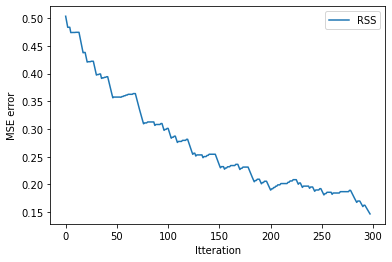

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(mse_err)), mse_err)
plt.legend(['RSS'])
plt.ylabel('MSE error')
plt.xlabel('Itteration')